# NLP - Embeddings, RNNs and LSTMs 


## Basic Assignment

The notebook will help you practice Many-to-One RNN architecture, as well as Many-to-Many architectures.

The regular part and the advanced part are included in two different notebooks.


In [229]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import numpy as np
import re
from matplotlib import pyplot as plt
from nltk.corpus import treebank
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import nltk
import tensorflow as tf

In [230]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Loading the dataset
We will work on a binary classification problem. The dataset is of two classes SPAM and NOT SPAM. 

In [231]:
dataset=pd.read_csv("spam-1.csv", encoding='ISO-8859-1')

In [232]:
X=dataset.v2

In [233]:
y=dataset.v1

### Exercise 1
Reuse your to_lower(X) function from the NLP basic lab, and the clean_text(X) function to lower case all documents in the dataset and then remove all numerical and special characters from the dataset.

In [234]:
def to_lower(dataframe):
    return dataframe.map(lambda row: row.lower())

def clean_text(dataframe):
    pattern = r'[^a-z\s]'
    return dataframe.map(lambda row: re.sub(pattern, '', row))

X = to_lower(X)
X = clean_text(X)
X

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in  a wkly comp to win fa cup final...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the nd time we have tried  contact u u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: v2, Length: 5572, dtype: object

### Exercise 2 
Create the ground truth vector **y** for the binary classification.
Check that the **y** vector is of shape(ne,1).

In [235]:
label_encoder = LabelEncoder()
label_encoder.fit(["spam", "ham"])
y = label_encoder.transform(y)

In [236]:
y

array([0, 0, 1, ..., 0, 0, 0])

### Exercise 3
Use Keras' Tokenizer class to vectorize the corpus. 
What we expect here is that the tokens will be encoded as integers.


Notice that tokenizing here is different from the tokenization process discussed in the basic lecture.

In [237]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)

In [238]:
i=25
print(X[i])
print(X_encoded[i])

just forced myself to eat a slice im really not hungry tho this sucks mark is getting worried he knows im sick when i turn down pizza lol
[36, 3982, 934, 1, 310, 4, 2715, 22, 146, 24, 735, 633, 39, 1218, 1107, 9, 242, 1015, 70, 935, 22, 1016, 43, 2, 1766, 223, 1108, 175]


### Exercise 4
Whether we work with an RNN cell, an LSTM or a GRU cell, we want first to know how many times should we unroll the network. This will be referred to as 'time_steps'.


In this exercise, the goal is to check the lengths of our documents, and then choose a fixed length for all our documents. 

Documents which are shorter than the length you fixed will be padded with 0s.

Documents which are longer will be truncated. 


a. Check the length of the largest document in the corpus

In [239]:
lengths = [len(x) for x in X_encoded]
max_len = max(lengths)
max_len

171

b. Check the average count of words in all documents

In [240]:
print("Average word count in our documents is", int(sum(lengths)/len(lengths)))

Average word count in our documents is 14


Quite a distance between the average length and longest document. It's probably worth it to check the lengths in a box plot.

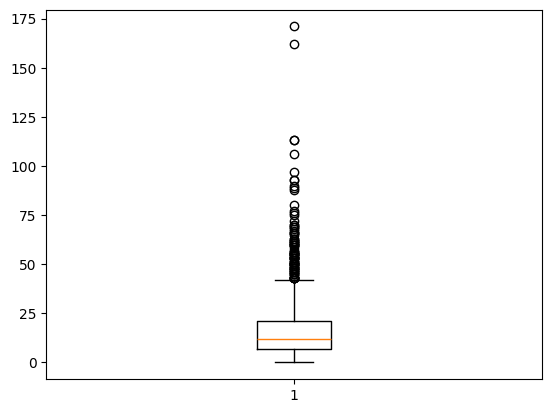

In [241]:
plt.boxplot(lengths)
plt.show()

### Exercise 5

Hopefully, you have chosen a value for the max doc length (which will serve as your time_steps value when you build your RNN).

We can now proceed to use the pad_sequences() method of Keras to pad our sequences, check [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences).

Sentences longer than **n** will be truncated (you can choose to keep the first **n** words or the last).
Sentences shorter than **n** will be padded with 0.

In [242]:
X_padded = pad_sequences(X_encoded, maxlen=max_len) # so we keep all words in our documents, and pad the shorter ones

In [243]:
i=5214
print(X[i])
print(X_encoded[i])
print(X_padded[i])
print(y[i])

natalja f is inviting you to be her friend reply yes or no see her wwwsmsacunat stop send stop frnd to 
[3883, 789, 9, 1377, 3, 1, 31, 105, 260, 88, 140, 26, 37, 80, 105, 3884, 84, 68, 84, 682, 1]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 3883  789    9 1377
    3    1   31  105  

### Exercise 6

We can now proceed to pass our padded sequences and our **y** vector to an RNN model for training.
Let's first define a simple RNN model.

In [244]:
# split entire data into training and testing sets
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=TEST_SIZE, random_state=100)

**Do check the size of the vocab, needed for the rest of the exercises.**

This dataset was chosen particularly for its small vocab size.

### Exercise7

Let's first try a classification task using basic RNN cells.

You're free to define the number of units and layers as you see fit.

a. Define the architecture of your model and print its summary.

In [245]:
embedding_dim = 32 # output dimension of the embedding layer
input_size = max_len # number of time steps
vocab_size = len(tokenizer.word_index) + 1 # size of the vocab
def build_model(inner_layer):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_size, trainable=False))
    model.add(inner_layer) # inner layer is the type of RNN cell we want to use
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

def compile_model(model, optimizer='rmsprop', loss='binary_crossentropy'):
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    return model

def train_model(model, epochs, batch_size):
    m_history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return m_history

In [246]:
model = build_model(SimpleRNN(embedding_dim))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 171, 32)           273312    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 275425 (1.05 MB)
Trainable params: 2113 (8.25 KB)
Non-trainable params: 273312 (1.04 MB)
_________________________________________________________________


b. Compile your model. 

Use the loss function and the optimizer you want, you don't have to use binary_cross entropy and stochastic gradient descent.

In [247]:
compile_model(model)

c. Train your model

In [248]:
m_history = train_model(model, epochs=50, batch_size=128)

Epoch 1/50
33/33 [==============================] - 1s 19ms/step - loss: 0.4462 - acc: 0.8404 - val_loss: 0.3799 - val_acc: 0.8722
Epoch 2/50
33/33 [==============================] - 1s 16ms/step - loss: 0.3965 - acc: 0.8607 - val_loss: 0.3692 - val_acc: 0.8722
Epoch 3/50
33/33 [==============================] - 1s 16ms/step - loss: 0.3532 - acc: 0.8636 - val_loss: 0.3049 - val_acc: 0.8729
Epoch 4/50
33/33 [==============================] - 1s 15ms/step - loss: 0.3182 - acc: 0.8665 - val_loss: 0.2691 - val_acc: 0.8909
Epoch 5/50
33/33 [==============================] - 1s 17ms/step - loss: 0.3018 - acc: 0.8643 - val_loss: 0.2598 - val_acc: 0.8859
Epoch 6/50
33/33 [==============================] - 1s 16ms/step - loss: 0.2911 - acc: 0.8749 - val_loss: 0.2609 - val_acc: 0.8787
Epoch 7/50
33/33 [==============================] - 1s 15ms/step - loss: 0.2778 - acc: 0.8851 - val_loss: 0.2634 - val_acc: 0.8866
Epoch 8/50
33/33 [==============================] - 1s 16ms/step - loss: 0.2848 - a

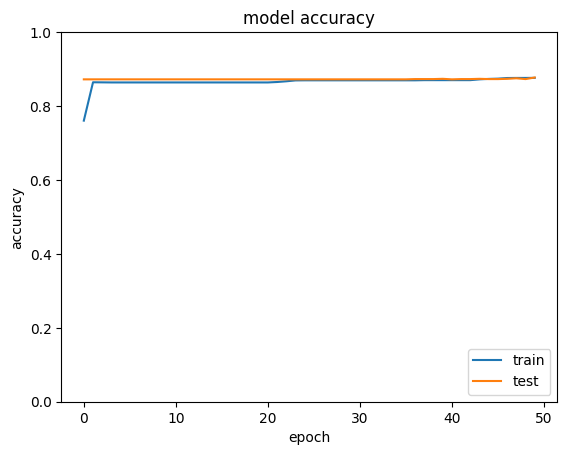

In [296]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 8
Try to perform the same classification task using an LSTM architecture.

a. Define the architecture of your model and print its summary.

In [250]:
model = build_model(LSTM(16))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 171, 32)           273312    
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 276465 (1.05 MB)
Trainable params: 3153 (12.32 KB)
Non-trainable params: 273312 (1.04 MB)
_________________________________________________________________


b. compile your model.

In [251]:
compile_model(model)

c. Train your model.

In [252]:
m_history = train_model(model, epochs=50, batch_size=256)

Epoch 1/50
17/17 [==============================] - 2s 58ms/step - loss: 0.6353 - acc: 0.8327 - val_loss: 0.4979 - val_acc: 0.8722
Epoch 2/50
17/17 [==============================] - 1s 41ms/step - loss: 0.4328 - acc: 0.8638 - val_loss: 0.3858 - val_acc: 0.8722
Epoch 3/50
17/17 [==============================] - 1s 43ms/step - loss: 0.3959 - acc: 0.8638 - val_loss: 0.3775 - val_acc: 0.8722
Epoch 4/50
17/17 [==============================] - 1s 42ms/step - loss: 0.3913 - acc: 0.8638 - val_loss: 0.3724 - val_acc: 0.8722
Epoch 5/50
17/17 [==============================] - 1s 42ms/step - loss: 0.3845 - acc: 0.8638 - val_loss: 0.3624 - val_acc: 0.8722
Epoch 6/50
17/17 [==============================] - 1s 42ms/step - loss: 0.3758 - acc: 0.8638 - val_loss: 0.3512 - val_acc: 0.8722
Epoch 7/50
17/17 [==============================] - 1s 42ms/step - loss: 0.3650 - acc: 0.8638 - val_loss: 0.3393 - val_acc: 0.8722
Epoch 8/50
17/17 [==============================] - 1s 43ms/step - loss: 0.3539 - a

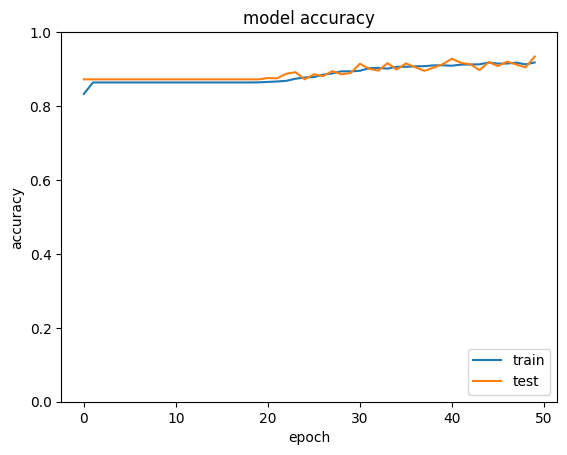

In [253]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 9

Let's now see whether we get different results using a GRU cell.

a. Define the architecture of your model and print its summary.

In [254]:
model = build_model(GRU(8))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 171, 32)           273312    
                                                                 
 gru_3 (GRU)                 (None, 8)                 1008      
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 274329 (1.05 MB)
Trainable params: 1017 (3.97 KB)
Non-trainable params: 273312 (1.04 MB)
_________________________________________________________________


b. Compile your model

In [255]:
compile_model(model)

c. Train your model

In [256]:
m_history = train_model(model, epochs=50, batch_size=512)

Epoch 1/50
9/9 [==============================] - 2s 80ms/step - loss: 0.6739 - acc: 0.7842 - val_loss: 0.6502 - val_acc: 0.8722
Epoch 2/50
9/9 [==============================] - 0s 48ms/step - loss: 0.6390 - acc: 0.8638 - val_loss: 0.6185 - val_acc: 0.8722
Epoch 3/50
9/9 [==============================] - 0s 49ms/step - loss: 0.6081 - acc: 0.8638 - val_loss: 0.5861 - val_acc: 0.8722
Epoch 4/50
9/9 [==============================] - 0s 47ms/step - loss: 0.5764 - acc: 0.8638 - val_loss: 0.5519 - val_acc: 0.8722
Epoch 5/50
9/9 [==============================] - 0s 49ms/step - loss: 0.5434 - acc: 0.8638 - val_loss: 0.5185 - val_acc: 0.8722
Epoch 6/50
9/9 [==============================] - 0s 49ms/step - loss: 0.5109 - acc: 0.8638 - val_loss: 0.4855 - val_acc: 0.8722
Epoch 7/50
9/9 [==============================] - 0s 47ms/step - loss: 0.4793 - acc: 0.8638 - val_loss: 0.4524 - val_acc: 0.8722
Epoch 8/50
9/9 [==============================] - 0s 47ms/step - loss: 0.4485 - acc: 0.8638 - val

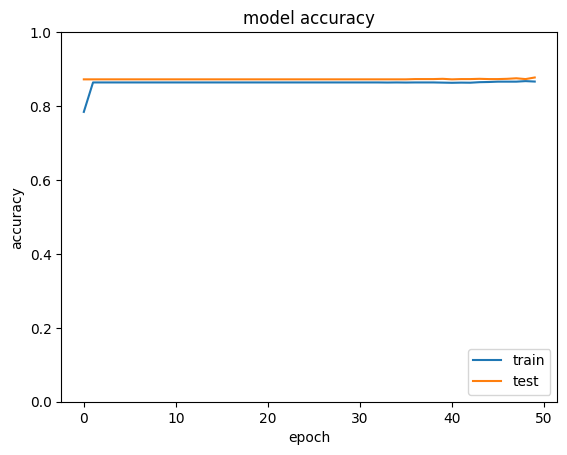

In [257]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 10
It's now time to try training our model using pretrained word embeddings.

a. First, get the pretrained word embeddings of your choice, you can get;

1. You can get Google word2vec from [here](https://code.google.com/archive/p/word2vec/), these embeddings are vectors of size 300
2. You can get Stanford's GloVe embeddings from [here](https://nlp.stanford.edu/projects/glove/), you are offered a choice between embedding vectors of sizes 40, 50, 100, 200 and 300

a. Use the Gensim library to load your embeddings

Feel free to use other libraries also.

In [258]:
from gensim.models import KeyedVectors
w2v_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

b. If you work with embeddings of size 300 for example, then create a matrix **embeddings**. The shape of the matrix is (vocab_size, embedding_size=300). Each row corresponds to the embeddings of one word in your vocab.

In [259]:
embeddings = np.zeros((len(tokenizer.word_index) + 1, w2v_google.vector_size))
for word,i in tokenizer.word_index.items():
    if word in w2v_google.key_to_index:
        embeddings[i] = w2v_google.get_vector(word)

c. Print the embedding_weights shape

In [260]:
embeddings.shape

(8541, 300)

### Exercise 11
Let's now retrain our models, Simple RNN, LSTM and GRU using these embeddings.

Let's start by doing it for RNN again.

Define the architecture of your model again, show its summary, compile it and train it.

In [261]:
simple_rnn_model = Sequential()
simple_rnn_model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings], input_length=max_len, trainable=False))
simple_rnn_model.add(SimpleRNN(1))
simple_rnn_model.add(Dense(1, activation='sigmoid'))
simple_rnn_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 171, 300)          2562300   
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 1)                 302       
                                                                 
 dense_22 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2562604 (9.78 MB)
Trainable params: 304 (1.19 KB)
Non-trainable params: 2562300 (9.77 MB)
_________________________________________________________________


In [262]:
compile_model(simple_rnn_model)

In [263]:
m_history = train_model(simple_rnn_model, epochs=50, batch_size=128)

Epoch 1/50
33/33 [==============================] - 2s 37ms/step - loss: 0.6658 - acc: 0.6382 - val_loss: 0.6460 - val_acc: 0.7251
Epoch 2/50
33/33 [==============================] - 1s 31ms/step - loss: 0.6271 - acc: 0.7784 - val_loss: 0.6125 - val_acc: 0.8098
Epoch 3/50
33/33 [==============================] - 1s 32ms/step - loss: 0.5949 - acc: 0.8342 - val_loss: 0.5803 - val_acc: 0.8579
Epoch 4/50
33/33 [==============================] - 1s 31ms/step - loss: 0.5654 - acc: 0.8636 - val_loss: 0.5514 - val_acc: 0.8715
Epoch 5/50
33/33 [==============================] - 1s 31ms/step - loss: 0.5394 - acc: 0.8708 - val_loss: 0.5271 - val_acc: 0.8787
Epoch 6/50
33/33 [==============================] - 1s 31ms/step - loss: 0.5168 - acc: 0.8751 - val_loss: 0.5057 - val_acc: 0.8787
Epoch 7/50
33/33 [==============================] - 1s 31ms/step - loss: 0.4973 - acc: 0.8753 - val_loss: 0.4878 - val_acc: 0.8808
Epoch 8/50
33/33 [==============================] - 1s 32ms/step - loss: 0.4797 - a

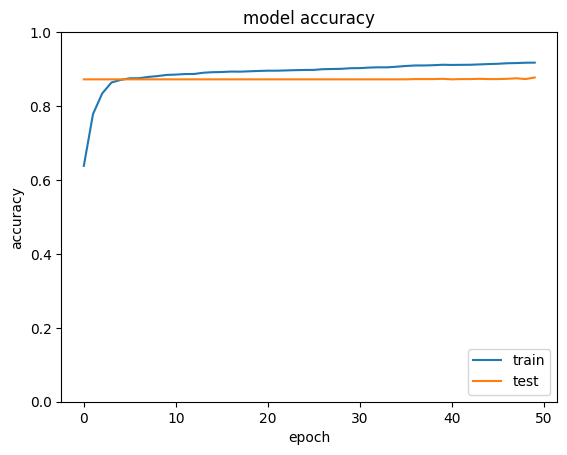

In [264]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 12

Let's now retrain the model with LSTM architecture.

Define the architecture of your model again, show its summary, compile it and train it.

In [265]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings], input_length=max_len, trainable=False))
lstm_model.add(LSTM(1))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 171, 300)          2562300   
                                                                 
 lstm_8 (LSTM)               (None, 1)                 1208      
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2563510 (9.78 MB)
Trainable params: 1210 (4.73 KB)
Non-trainable params: 2562300 (9.77 MB)
_________________________________________________________________


In [266]:
compile_model(lstm_model, optimizer='adam')

In [267]:
m_history = train_model(lstm_model, epochs=50, batch_size=512)

Epoch 1/50
9/9 [==============================] - 3s 197ms/step - loss: 0.6268 - acc: 0.7423 - val_loss: 0.5523 - val_acc: 0.8701
Epoch 2/50
9/9 [==============================] - 1s 145ms/step - loss: 0.5332 - acc: 0.8626 - val_loss: 0.5100 - val_acc: 0.8722
Epoch 3/50
9/9 [==============================] - 1s 136ms/step - loss: 0.5020 - acc: 0.8638 - val_loss: 0.4877 - val_acc: 0.8722
Epoch 4/50
9/9 [==============================] - 1s 125ms/step - loss: 0.4834 - acc: 0.8638 - val_loss: 0.4711 - val_acc: 0.8722
Epoch 5/50
9/9 [==============================] - 1s 127ms/step - loss: 0.4692 - acc: 0.8638 - val_loss: 0.4588 - val_acc: 0.8722
Epoch 6/50
9/9 [==============================] - 1s 127ms/step - loss: 0.4582 - acc: 0.8638 - val_loss: 0.4485 - val_acc: 0.8722
Epoch 7/50
9/9 [==============================] - 1s 126ms/step - loss: 0.4487 - acc: 0.8638 - val_loss: 0.4395 - val_acc: 0.8722
Epoch 8/50
9/9 [==============================] - 1s 124ms/step - loss: 0.4403 - acc: 0.86

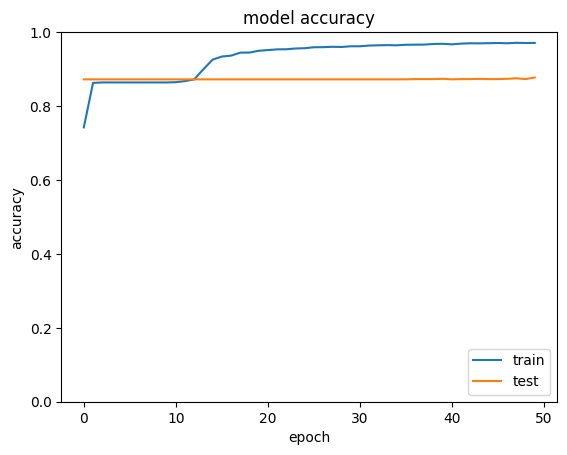

In [268]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 13

Let's now retrain the model with GRU architecture.

Define the architecture of your model again, show its summary, compile it and train it.

In [269]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings], input_length=max_len, trainable=False))
gru_model.add(GRU(1))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 171, 300)          2562300   
                                                                 
 gru_4 (GRU)                 (None, 1)                 909       
                                                                 
 dense_24 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2563211 (9.78 MB)
Trainable params: 911 (3.56 KB)
Non-trainable params: 2562300 (9.77 MB)
_________________________________________________________________


In [270]:
compile_model(gru_model, optimizer='rmsprop')

In [323]:
m_history = train_model(gru_model, epochs=50, batch_size=512)

Epoch 1/50
7/7 [==============================] - 1s 106ms/step - loss: 0.0663 - acc: 0.9208 - val_loss: 0.0658 - val_acc: 0.9218
Epoch 2/50
7/7 [==============================] - 1s 102ms/step - loss: 0.0659 - acc: 0.9210 - val_loss: 0.0654 - val_acc: 0.9218
Epoch 3/50
7/7 [==============================] - 1s 102ms/step - loss: 0.0654 - acc: 0.9210 - val_loss: 0.0649 - val_acc: 0.9219
Epoch 4/50
7/7 [==============================] - 1s 101ms/step - loss: 0.0649 - acc: 0.9212 - val_loss: 0.0644 - val_acc: 0.9221
Epoch 5/50
7/7 [==============================] - 1s 102ms/step - loss: 0.0644 - acc: 0.9214 - val_loss: 0.0639 - val_acc: 0.9223
Epoch 6/50
7/7 [==============================] - 1s 101ms/step - loss: 0.0639 - acc: 0.9216 - val_loss: 0.0634 - val_acc: 0.9225
Epoch 7/50
7/7 [==============================] - 1s 104ms/step - loss: 0.0635 - acc: 0.9218 - val_loss: 0.0630 - val_acc: 0.9224
Epoch 8/50
7/7 [==============================] - 1s 103ms/step - loss: 0.0630 - acc: 0.92

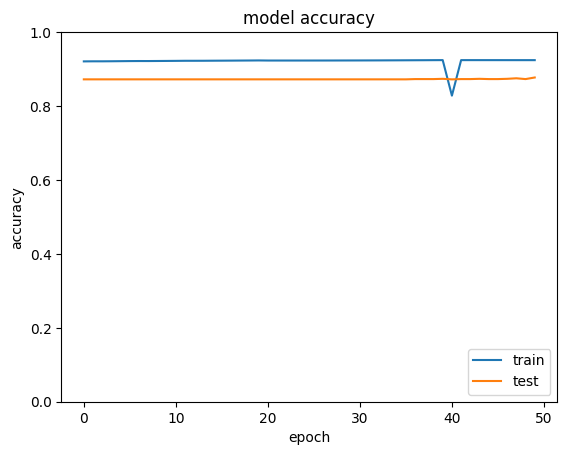

In [324]:
# visualise training history
plt.plot(m_history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 14

By now, hopefully the many-to-one RNN type makes sense. Let's now try a diffrent type, many-to-many.

We wish to build our own POS tagger. Recall how POS tags help us understand a first layer of the syntactic structure of a given sentence. 

There are various ways with which you can build a POS tagger. A rule-based one, a probabilistic one, using Hidden Markov Models (HMMs). There's also an option to build a statistical model to learn a POS tagger. 

We'll try the statistical approach. The training data is abundant, available through NLTK even.

We'll first acquire the TreeBank dataset.

In [273]:
#You might need to download the dataset first
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [274]:
corpus = treebank.tagged_sents(tagset='universal')

Notice that each entry in the dataset is a tuple (word, pos_tag). We want our training **X** to have the words of the sentence, and **Y** to have the equivalent POS tags.

In [275]:
i=25
print(type(corpus[i]))
print(corpus[i])

<class 'list'>
[('By', 'ADP'), ('1997', 'NUM'), (',', '.'), ('almost', 'ADV'), ('all', 'DET'), ('remaining', 'VERB'), ('uses', 'NOUN'), ('of', 'ADP'), ('cancer-causing', 'ADJ'), ('asbestos', 'NOUN'), ('will', 'VERB'), ('be', 'VERB'), ('outlawed', 'VERB'), ('*-6', 'X'), ('.', '.')]


a. Create your frame X which has all the sentences, and a frame Y with all the POS tags.

In [276]:
X = []
Y = []
for sentence in corpus:
    x = []
    y = []
    for word, pos_tag in sentence:
        x.append(word)
        y.append(pos_tag)
    X.append(x)
    Y.append(y)

In [277]:
i=0
print(X[i])
print(Y[i])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']


### Exercise 15

Check that you have the same number of entries in X and Y.

Check also that every entry in X, has the same number of elements as in its equivalent of Y.

If a sentence in X has 5 tokens, we need to have 5 POS tags in Y.

In [278]:
if len(X) == len(Y):
    print("Number of entries in X and Y are the same.")
else:
    print("Number of entries in X and Y are different.")
    
for i in range(len(X)):
    if len(X[i]) != len(Y[i]):
        print("Shape Error")
        break

Number of entries in X and Y are the same.


3914 sentences is enough training data for our model.

### Exercise 16

a. Let's now move on to convert X and Y both to integers, using Keras's tokenizer.

In [279]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)

tokenizer.fit_on_texts(Y)
Y_encoded = tokenizer.texts_to_sequences(Y)

a. Let's print the size of the vocab, also the number of different POS tags we have.

We need to know how many different POS tags we have, because that should be our number of classes.

In [280]:
print("Vocab size is", len(tokenizer.word_index)) # number of unique words in our corpus

Vocab size is 11397


### Exercise 17

Let's again pad our sentences and our tags. We, again, need to decide on our max length, a decision that is crucial as this matches the number of time steps for our RNN architecture

In [281]:
lengths = [len(x) for x in X_encoded]
max_length = max(lengths)

X_padded = pad_sequences(X_encoded, maxlen=max_length, padding='pre', truncating='pre')
Y_padded = pad_sequences(Y_encoded, maxlen=max_length, padding='pre', truncating='pre')

In [282]:
i=0
print(X_padded[i])
print(Y_padded[i])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### Exercise 18

Try a first version of your RNN models without using any pretrained embeddings.


a. Let's one-hot encode Y

In [283]:
Y = to_categorical(Y_padded)

b. We create a train and test set.

In [284]:
# split entire data into training and testing sets
TEST_SIZE = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_padded, Y, test_size=TEST_SIZE, random_state=100)

c. Define your RNN model, using a simple RNN. Compile it and fit it to the data.

Do not forget to wrap your Dense output layer with the TimeDistributed wrapper. We're doing a multiclassification at each time step.

In [285]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_length, trainable=False))
rnn_model.add(SimpleRNN(1, activation='relu', return_sequences=True))
rnn_model.add(TimeDistributed(Dense(len(Y[0][0]), activation='softmax')))
rnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 271, 32)           364736    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 271, 1)            34        
                                                                 
 time_distributed_3 (TimeDi  (None, 271, 16)           32        
 stributed)                                                      
                                                                 
Total params: 364802 (1.39 MB)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 364736 (1.39 MB)
_________________________________________________________________


In [286]:
compile_model(rnn_model, optimizer='adam', loss='categorical_crossentropy')

In [320]:
m_history = train_model(rnn_model, epochs=100, batch_size=256)

Epoch 1/100
13/13 [==============================] - 1s 52ms/step - loss: 0.1987 - acc: 0.9048 - val_loss: 0.1978 - val_acc: 0.9063
Epoch 2/100
13/13 [==============================] - 1s 50ms/step - loss: 0.1972 - acc: 0.9048 - val_loss: 0.1964 - val_acc: 0.9063
Epoch 3/100
13/13 [==============================] - 1s 50ms/step - loss: 0.1958 - acc: 0.9048 - val_loss: 0.1949 - val_acc: 0.9063
Epoch 4/100
13/13 [==============================] - 1s 52ms/step - loss: 0.1944 - acc: 0.9048 - val_loss: 0.1935 - val_acc: 0.9063
Epoch 5/100
13/13 [==============================] - 1s 51ms/step - loss: 0.1930 - acc: 0.9048 - val_loss: 0.1920 - val_acc: 0.9063
Epoch 6/100
13/13 [==============================] - 1s 49ms/step - loss: 0.1915 - acc: 0.9048 - val_loss: 0.1906 - val_acc: 0.9063
Epoch 7/100
13/13 [==============================] - 1s 50ms/step - loss: 0.1901 - acc: 0.9048 - val_loss: 0.1892 - val_acc: 0.9063
Epoch 8/100
13/13 [==============================] - 1s 49ms/step - loss: 0.

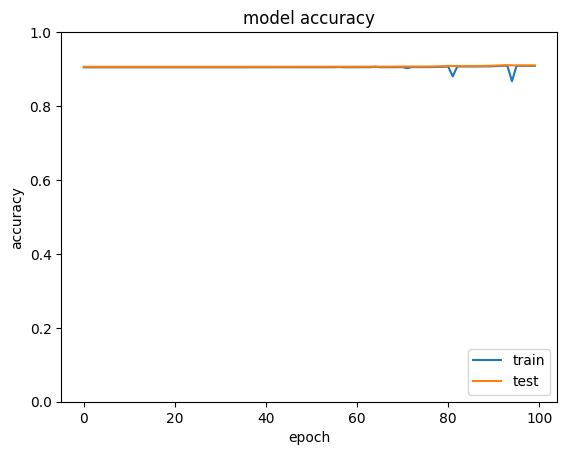

In [321]:
plt.plot(m_history.history['acc'])
plt.plot(m_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 19
Retrain the model with an LSTM. 
This should work faster, and yield better results.
Define, compile and fit your model.

In [289]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_length, trainable=False))
lstm_model.add(LSTM(1, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(len(Y[0][0]), activation='softmax')))
lstm_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 271, 32)           364736    
                                                                 
 lstm_9 (LSTM)               (None, 271, 1)            136       
                                                                 
 time_distributed_4 (TimeDi  (None, 271, 16)           32        
 stributed)                                                      
                                                                 
Total params: 364904 (1.39 MB)
Trainable params: 168 (672.00 Byte)
Non-trainable params: 364736 (1.39 MB)
_________________________________________________________________


In [290]:
compile_model(lstm_model, optimizer='adam', loss='categorical_crossentropy')

In [316]:
m_history = train_model(lstm_model, epochs=100, batch_size=256)

Epoch 1/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0300 - acc: 0.9048 - val_loss: 0.0296 - val_acc: 0.9063
Epoch 2/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0299 - acc: 0.9048 - val_loss: 0.0294 - val_acc: 0.9063
Epoch 3/100
13/13 [==============================] - 1s 66ms/step - loss: 0.0297 - acc: 0.9048 - val_loss: 0.0293 - val_acc: 0.9063
Epoch 4/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0295 - acc: 0.9048 - val_loss: 0.0291 - val_acc: 0.9063
Epoch 5/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0293 - acc: 0.9048 - val_loss: 0.0289 - val_acc: 0.9063
Epoch 6/100
13/13 [==============================] - 1s 66ms/step - loss: 0.0292 - acc: 0.9048 - val_loss: 0.0288 - val_acc: 0.9063
Epoch 7/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0290 - acc: 0.9048 - val_loss: 0.0286 - val_acc: 0.9063
Epoch 8/100
13/13 [==============================] - 1s 66ms/step - loss: 0.

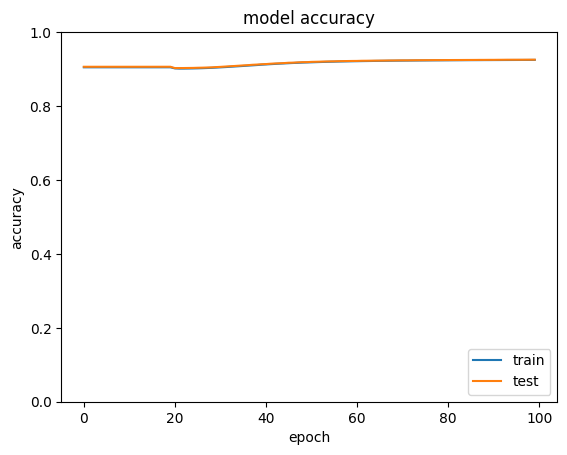

In [319]:
plt.plot(m_history.history['acc'])
plt.plot(m_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 20
Retrain the model with a GRU. 

In [297]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_length, trainable=False))
gru_model.add(GRU(1, activation='relu', return_sequences=True))
gru_model.add(TimeDistributed(Dense(len(Y[0][0]), activation='softmax')))
gru_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 271, 32)           364736    
                                                                 
 gru_5 (GRU)                 (None, 271, 1)            105       
                                                                 
 time_distributed_5 (TimeDi  (None, 271, 16)           32        
 stributed)                                                      
                                                                 
Total params: 364873 (1.39 MB)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 364736 (1.39 MB)
_________________________________________________________________


In [304]:
compile_model(gru_model, optimizer='adam', loss='categorical_crossentropy')

In [307]:
m_history = train_model(gru_model, epochs=100, batch_size=512)

Epoch 1/100
7/7 [==============================] - 1s 106ms/step - loss: 0.1290 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.9063
Epoch 2/100
7/7 [==============================] - 1s 102ms/step - loss: 0.1283 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.9063
Epoch 3/100
7/7 [==============================] - 1s 101ms/step - loss: 0.1276 - acc: 0.9048 - val_loss: 0.1269 - val_acc: 0.9063
Epoch 4/100
7/7 [==============================] - 1s 101ms/step - loss: 0.1269 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.9063
Epoch 5/100
7/7 [==============================] - 1s 103ms/step - loss: 0.1262 - acc: 0.9048 - val_loss: 0.1256 - val_acc: 0.9063
Epoch 6/100
7/7 [==============================] - 1s 104ms/step - loss: 0.1255 - acc: 0.9048 - val_loss: 0.1249 - val_acc: 0.9063
Epoch 7/100
7/7 [==============================] - 1s 102ms/step - loss: 0.1248 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.9063
Epoch 8/100
7/7 [==============================] - 1s 102ms/step - loss: 0.1242 - a

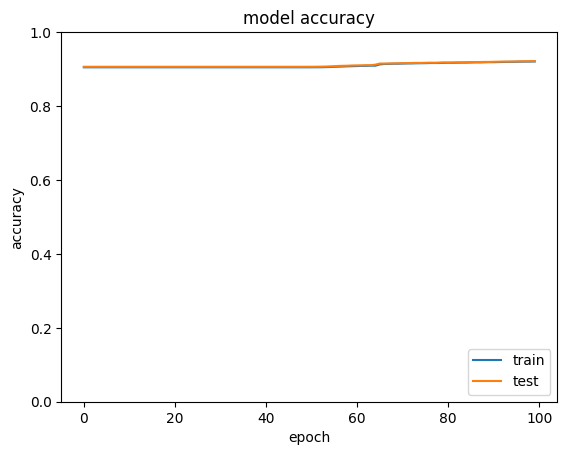

In [313]:
plt.plot(m_history.history['acc'])
plt.plot(m_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Exercise 21
Save one of your models (the one with the best performance) as an h5 file. This is a straightforward operation, refer to [here](https://keras.io/api/models/model_saving_apis/).

You will use it on the **regular** part of the assignment to make inferences.

In [326]:
gru_model.save('gru_model_group6', save_format='h5')

C:\Users\Aryan\Desktop\Mod 9\XAI & Ethics\XAI\Lecture1\pythonProject\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
